In [1]:
import keras
import numpy as np
from sklearn import model_selection, preprocessing, metrics, utils
import pandas as pd
import matplotlib.pyplot as plt
import fraudutils as futils
rs = 1

Using TensorFlow backend.


In [2]:
def plot_results(p1, p2, legend):
    plt.title(legend)
    plt.plot(p1)
    plt.plot(p2)
    plt.legend([legend, 'Validation ' + legend])
    plt.ylabel(legend)
    plt.xlabel('Epochs')
    plt.show()

In [3]:
data = pd.read_csv('../../../data/raw/give-me-some-credit/cs-training.csv')
del data['Unnamed: 0']
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(1)
data['MonthlyIncome'] = data['MonthlyIncome'].fillna(data['MonthlyIncome'].mean())
data.shape

(150000, 11)

In [4]:
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [5]:
X_ = data.drop('SeriousDlqin2yrs', axis=1)
y_ = data['SeriousDlqin2yrs']

In [6]:
X_ = preprocessing.MinMaxScaler().fit_transform(X_)

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_, y_, test_size=0.4, stratify=y_, random_state=rs)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_test, y_test, test_size=0.25, stratify=y_test, random_state=rs)

print(len(X_train), len(X_test), len(X_val))

90000 45000 15000


In [8]:
class AUCCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_aucroc = []
        self.test_aucroc = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        prediction_train = model.predict_classes(X_train)
        prediction_test = model.predict_classes(X_test)
        
        aucroc_train = metrics.roc_auc_score(y_train, prediction_train)
        aucroc_test = metrics.roc_auc_score(y_test, prediction_test)
        
        print("Aucroc train: {0:.4f}, Aucroc test: {1:.4f}\n".format(aucroc_train, aucroc_test))
        
        self.train_aucroc.append(aucroc_train)
        self.test_aucroc.append(aucroc_test)   
        
auc_callback = AUCCallback()

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(10, input_shape=(10,)))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(10))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(10))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [10]:
results = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, 
                    batch_size=256, 
                    verbose=2,
                    callbacks=[auc_callback])

Train on 90000 samples, validate on 45000 samples
Epoch 1/10
 - 1s - loss: 0.2823 - acc: 0.9332 - val_loss: 0.2352 - val_acc: 0.9332
Aucroc train: 0.5000, Aucroc test: 0.5000

Epoch 2/10
 - 1s - loss: 0.2324 - acc: 0.9333 - val_loss: 0.2271 - val_acc: 0.9334
Aucroc train: 0.5070, Aucroc test: 0.5076

Epoch 3/10
 - 1s - loss: 0.2235 - acc: 0.9334 - val_loss: 0.2166 - val_acc: 0.9335
Aucroc train: 0.5078, Aucroc test: 0.5084

Epoch 4/10
 - 1s - loss: 0.2120 - acc: 0.9336 - val_loss: 0.2048 - val_acc: 0.9345
Aucroc train: 0.5161, Aucroc test: 0.5192

Epoch 5/10
 - 1s - loss: 0.2012 - acc: 0.9351 - val_loss: 0.1964 - val_acc: 0.9356
Aucroc train: 0.5599, Aucroc test: 0.5606

Epoch 6/10
 - 1s - loss: 0.1954 - acc: 0.9365 - val_loss: 0.1940 - val_acc: 0.9356
Aucroc train: 0.5876, Aucroc test: 0.5891

Epoch 7/10
 - 1s - loss: 0.1935 - acc: 0.9362 - val_loss: 0.1922 - val_acc: 0.9357
Aucroc train: 0.5885, Aucroc test: 0.5906

Epoch 8/10
 - 1s - loss: 0.1925 - acc: 0.9361 - val_loss: 0.1935 - v

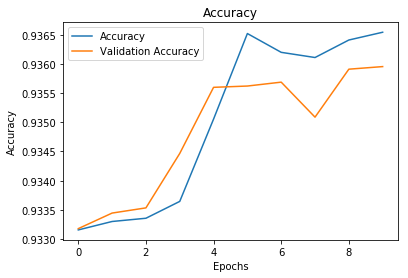

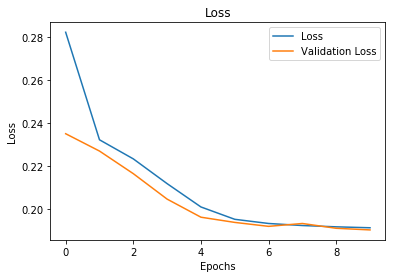

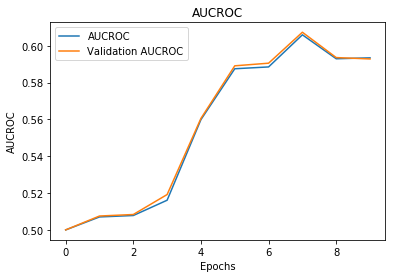

In [11]:
plot_results(results.history['acc'], results.history['val_acc'], 'Accuracy')
plot_results(results.history['loss'], results.history['val_loss'], 'Loss')
plot_results(auc_callback.train_aucroc, auc_callback.test_aucroc, 'AUCROC')

In [12]:
from collections import Counter
prediction_counter = Counter([x[0] for x in model.predict_classes(X_val)])
real_counter = Counter(y_val)
print("Prediction: {}\nReal: {}".format(prediction_counter, real_counter))

Prediction: Counter({0: 14649, 1: 351})
Real: Counter({0: 13997, 1: 1003})


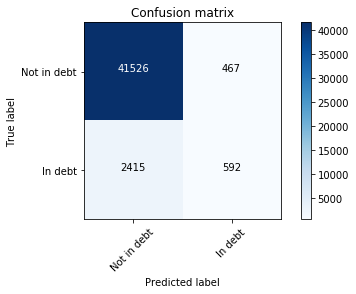

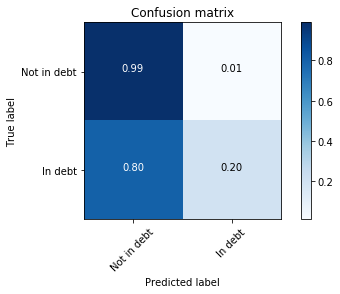

In [13]:
prediction = model.predict_classes(X_test)
cm = futils.confusion_matrix(y_test, prediction)
futils.plot_confusion_matrix(cm, classes=['Not in debt', 'In debt'])
futils.plot_confusion_matrix(cm, classes=['Not in debt', 'In debt'], normalize=True)

## Applying Oversampling

In [14]:
import imblearn.over_sampling

In [15]:
smote = imblearn.over_sampling.SMOTE(random_state=rs)

In [16]:
X_train_oversampled, y_train_oversampled = smote.fit_sample(X_train, y_train)

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(10, input_shape=(10,)))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(10))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(10))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [18]:
results = model.fit(X_train_oversampled, 
                    y_train_oversampled, 
                    validation_data=(X_test, y_test), 
                    epochs=10, 
                    batch_size=256, 
                    verbose=2,
                    callbacks=[auc_callback])

Train on 167968 samples, validate on 45000 samples
Epoch 1/10
 - 1s - loss: 0.6527 - acc: 0.6099 - val_loss: 0.7177 - val_acc: 0.5322
Aucroc train: 0.6525, Aucroc test: 0.6567

Epoch 2/10
 - 1s - loss: 0.5748 - acc: 0.7017 - val_loss: 0.5957 - val_acc: 0.7486
Aucroc train: 0.7422, Aucroc test: 0.7446

Epoch 3/10
 - 1s - loss: 0.5217 - acc: 0.7530 - val_loss: 0.6465 - val_acc: 0.7328
Aucroc train: 0.7536, Aucroc test: 0.7543

Epoch 4/10
 - 1s - loss: 0.5084 - acc: 0.7621 - val_loss: 0.5511 - val_acc: 0.7811
Aucroc train: 0.7602, Aucroc test: 0.7635

Epoch 5/10
 - 1s - loss: 0.5005 - acc: 0.7675 - val_loss: 0.5767 - val_acc: 0.7569
Aucroc train: 0.7585, Aucroc test: 0.7577

Epoch 6/10
 - 1s - loss: 0.4953 - acc: 0.7714 - val_loss: 0.3290 - val_acc: 0.8706
Aucroc train: 0.7490, Aucroc test: 0.7541

Epoch 7/10
 - 1s - loss: 0.4922 - acc: 0.7743 - val_loss: 0.4436 - val_acc: 0.8183
Aucroc train: 0.7600, Aucroc test: 0.7630

Epoch 8/10
 - 1s - loss: 0.4898 - acc: 0.7754 - val_loss: 0.7750 - 

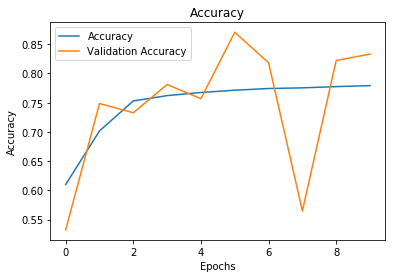

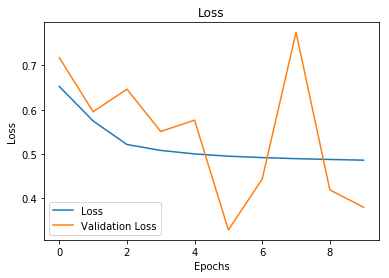

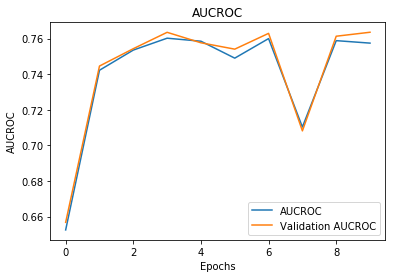

In [19]:
plot_results(results.history['acc'], results.history['val_acc'], 'Accuracy')
plot_results(results.history['loss'], results.history['val_loss'], 'Loss')
plot_results(auc_callback.train_aucroc, auc_callback.test_aucroc, 'AUCROC')

In [20]:
from collections import Counter
prediction_counter = Counter([x[0] for x in model.predict_classes(X_val)])
real_counter = Counter(y_val)
print("Prediction: {}\nReal: {}".format(prediction_counter, real_counter))


Prediction: Counter({0: 12158, 1: 2842})
Real: Counter({0: 13997, 1: 1003})


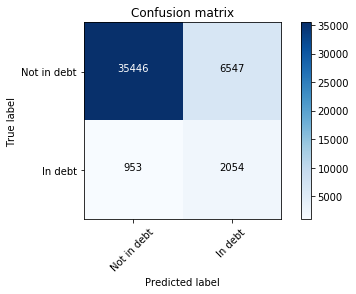

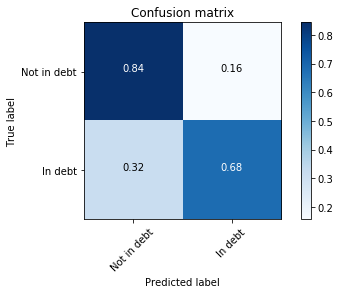

In [21]:
prediction = model.predict_classes(X_test)
cm = futils.confusion_matrix(y_test, prediction)
futils.plot_confusion_matrix(cm, classes=['Not in debt', 'In debt'])
futils.plot_confusion_matrix(cm, classes=['Not in debt', 'In debt'], normalize=True)